In [1]:
# https://note.com/npaka/n/n90bafa7b87d3
!pip install transformers --quiet

In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

# プロセッサとモデルの準備
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

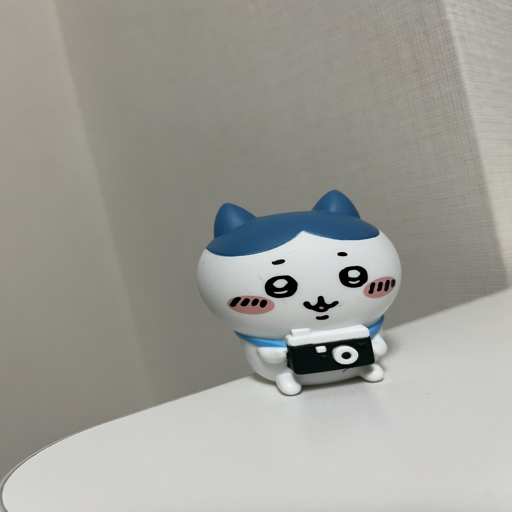

In [3]:
from PIL import Image

# 画像の読み込み
image = Image.open("IMG_0870.jpg").resize((512,512))
image

In [4]:
# プロンプトの準備
prompts = ["figure"]

In [5]:
import torch

# 推論の実行
inputs = processor(
    text=prompts, 
    images=[image] * len(prompts), 
    padding="max_length", 
    return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
preds = outputs.logits.unsqueeze(0).unsqueeze(0)

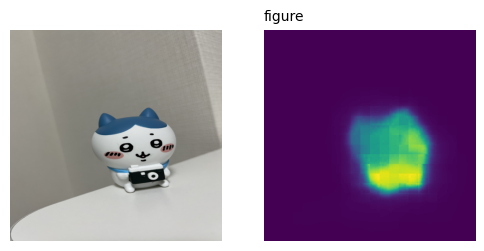

In [6]:
import matplotlib.pyplot as plt

# 結果の表示
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

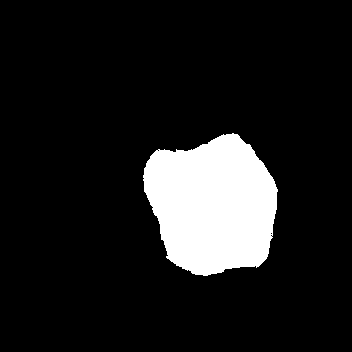

In [11]:
import cv2 

# マスクの生成
plt.imsave("seg.png", torch.sigmoid(preds[0][0]))
gray_image = cv2.cvtColor(cv2.imread("seg.png"), cv2.COLOR_BGR2GRAY)
(thresh, bw_image) = cv2.threshold(gray_image, 80, 255, cv2.THRESH_BINARY)
cv2.imwrite("mask.png", bw_image)
Image.open("mask.png")

In [12]:
!pip install diffusers transformers accelerate scipy safetensors --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
from diffusers import StableDiffusionInpaintPipeline
import torch

# パイプラインの準備
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to("cuda")

  0%|          | 0/25 [00:00<?, ?it/s]

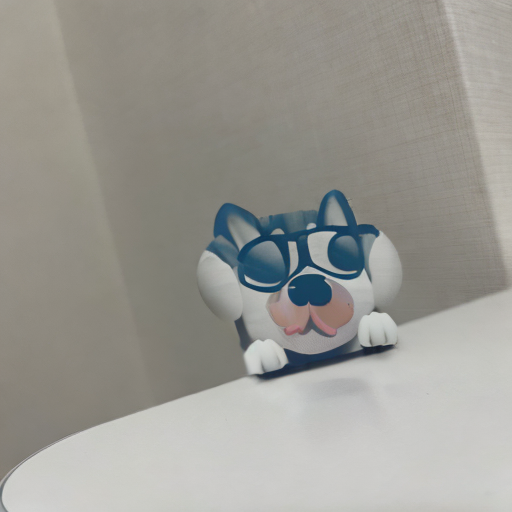

In [16]:
from PIL import Image

# パラメータ
prompt = "dog in the room"
init_image = Image.open("IMG_0870.jpg").resize((512,512)).convert("RGB")
mask_image = Image.open("mask.png").resize((512,512)).convert("RGB")

# インペインティング
image = pipe(
    prompt=prompt, 
    image=init_image, 
    mask_image=mask_image, 
    num_inference_steps=25
).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

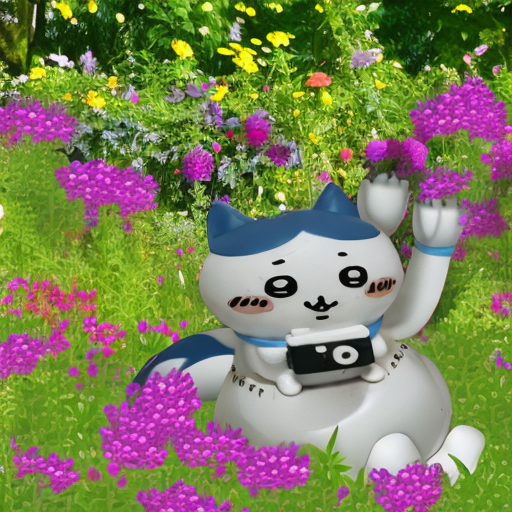

In [21]:
from PIL import Image, ImageOps

# パラメータ
prompt = "cat in the flower garden"
init_image = Image.open("IMG_0870.jpg").resize((512,512)).convert("RGB")
mask_image = Image.open("mask.png").resize((512,512)).convert("RGB")
mask_image = ImageOps.invert(mask_image)

# インペインティング
image = pipe(
    prompt=prompt, 
    image=init_image, 
    mask_image=mask_image, 
    num_inference_steps=25
).images[0]
image